# Project 7: Random Forest

![](https://ars.els-cdn.com/content/image/1-s2.0-S0031320310003973-gr1.jpg)

## Instructions

### Description

In this project, we are going to explore Random Forest Regressors for predicting the weather, specifically the temperature. You'll load the data in, set up a Random Forest, then test its performance on both the original data set and new data. This new data will be the current weather conditions and will come from an Application Programming Interface(API).

### Grading

For grading purposes, we will clear all outputs from all your cells and then run them all from the top.  Please test your notebook in the same fashion before turning it in.

### Submitting Your Solution

To submit your notebook, first clear all the cells (this won't matter too much this time, but for larger data sets in the future, it will make the file smaller).  Then use the File->Download As->Notebook to obtain the notebook file.  Finally, submit the notebook file on Canvas.

## Side note:
Most of the tasks below require you use specific variable names. This is so that the cells with "assert" statements in them can check if you did the tasks correctly.

In [1]:
# this might be necessary
#!pip3 install pprint

In [2]:
import json
import pydot
import requests
import graphviz
import numpy as np
import pandas as pd
from pprint import pprint
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, explained_variance_score

## Loading the data
You're given a csv file, ```temps.csv```, with weather data in Seattle from 2016.

## Tasks:
- Read in the file into a dataframe called `data`
- Run `get_dummies()` on the day of the week
- Specify the predictors (features) and targets:
 - Predictors: 'temp_1', 'temp_2', 'average', and the days of the week
 - Target: 'actual' (the actual temperature on the specified date)
- Split the data into training and testing sets

In [3]:
# read csv
data = pd.read_csv('temps.csv')
data.info()
data.head()
data.tail()

# get_dummies
data = pd.get_dummies(data, columns=['week'])
data.head()

# train_test_split 
features = ['temp_1', 'temp_2', 'average','week_Fri', 'week_Mon', 'week_Sat', 'week_Thurs', 'week_Sun', 'week_Tues', 'week_Wed' ]    
target = ['actual']

X = pd.DataFrame(data,columns = features)
y = pd.DataFrame(data, columns = target)
print("\nX.shape: ", X.shape)
print("Y.shape: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print("\nX_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)

print("\nX_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            348 non-null    int64  
 1   month           348 non-null    int64  
 2   day             348 non-null    int64  
 3   week            348 non-null    object 
 4   temp_2          348 non-null    int64  
 5   temp_1          348 non-null    int64  
 6   average         348 non-null    float64
 7   actual          348 non-null    int64  
 8   forecast_noaa   348 non-null    int64  
 9   forecast_acc    348 non-null    int64  
 10  forecast_under  348 non-null    int64  
 11  friend          348 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 32.8+ KB

X.shape:  (348, 10)
Y.shape:  (348, 1)

X_train.shape:  (278, 10)
y_train.shape:  (278, 1)

X_test.shape:  (70, 10)
y_test.shape:  (70, 1)


In [4]:
for column in ['week_Fri', 'week_Mon', 'week_Sat', 'week_Thurs', 'week_Sun', 'week_Tues', 'week_Wed']:
    assert column in data.columns

## Random Forest 

### Background
Random Forests, aka Random Decision Trees, are an example of "ensemble: learning methods. They operate by constructing many decision trees at once and outputting their mean prediction. This is useful because decision trees on their own are prone to overfitting. Random Forests are most often used for classification and regression, but today, we'll only be doing regression.

### Tasks 
- Initialize a `RandomForestRegressor` with 1000 estimators and a max_depth of 10. The model will perform well with these values, but you can always change them later. Store the regressor in the variable `rf_clf`.
 - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html 
- Fit the model with `rf_clf.fit()`

In [5]:
## initialize model
rf_clf = RandomForestRegressor(n_estimators = 1000, max_depth =10,random_state = 0)

In [6]:
## training
rf_clf.fit(X_train,y_train) 

C:\Software\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(max_depth=10, n_estimators=1000, random_state=0)

## Tree Visualization

The next cell plots an image of one of the trees in the forest. It also  
saves a png image file in the same directory as this jupyter notebook file.

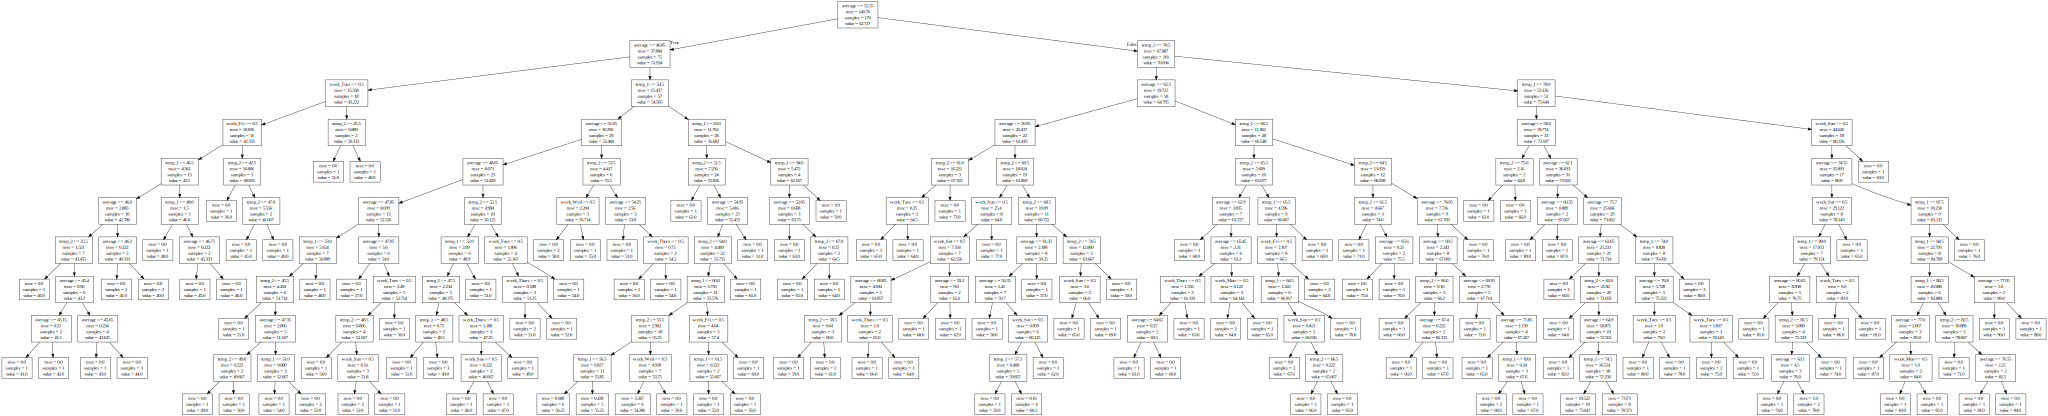

In [7]:
# Plot a decision tree
index = 5
tree = rf_clf.estimators_[index]
from IPython.display import display
columns = list(X_train.columns)
display(graphviz.Source(export_graphviz(tree, feature_names=columns, class_names=True, out_file=None)))

# Save image to png file
export_graphviz(tree, out_file = 'tree.dot', feature_names = features, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

## Importance Visualization

Plot the learned importance of the features

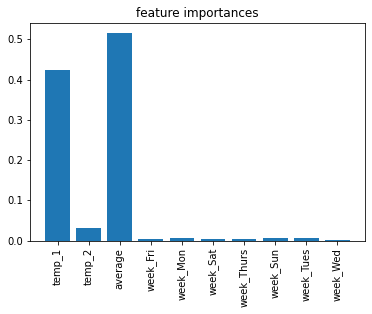

In [8]:
# Plot importances
importances = list(rf_clf.feature_importances_)
labeled_importances = [(feature, round(importance, 2)) for feature, importance in zip(features, importances)]
indices = range(len(importances))
plt.bar(indices, importances, orientation = 'vertical')
plt.title('feature importances')
plt.xticks(indices, features, rotation='vertical')
plt.show()

## Testing
First, we are going to use the test set to make predictions, same as always. Then we're going to get new data from an API.

### Tasks
- Find the R^2 value. Do this with `model.score()` or `sklearn.metrics.r2_score()` and save to a variable called `r2`. 
- Find the explained variance with `sklearn.metrics.explained_variance_score()` and save to a variable called `ev`.

For both of these metrics, the closer to 1, the better.

In [9]:
r2 = rf_clf.score(X_test, y_test)
print("\n r2_score : ", r2)

y_pred =  rf_clf.predict(X_test)
ev = explained_variance_score(y_test, y_pred)
print("\n explained_variance_score : ", ev)


 r2_score :  0.8350348817310049

 explained_variance_score :  0.8364737048161126


In [10]:
assert r2 > 0.7
assert ev > 0.7

### API
#### Background
An application programming interface (API) is just another way to gather data by letting clients (us and our computers) programmatically interact with servers. Today, we're going to be using a weather API for getting the current temp of a location.

##### JSON
JavaScript Object Notation is a very popular data format, especially for APIs. It appears very similar to Python's dictionaries, with curly braces to start, then key-value pairs of data. An example for a person could be:
```
{
    'firstname': 'John',
    'lastname': 'Doe',
    'age': 55,
    'retired': true,
    'addresses': ['123 street', '456 street']
}
```
When we make an API request, the server will handle it, then respond with a bunch of JSON, which we can grab exactly what we want from.

#### OpenWeatherMap API
Let's use the OpenWeatherMap API to get the current weather. The documentation is [here](https://openweathermap.org/current). To do so, we use the `requests` library. Making a request is very similar to going to a website in a browser -- a URL points to a location or resource on a server and that server fulfills the tasks we ask it to.
<br>
The URL is `'http://api.openweathermap.org/data/2.5/weather?q={city name},{country code}'`, where we fill in the city name and country code(without the curly braces).
<br>
An example response the API would send: https://samples.openweathermap.org/data/2.5/weather?q=London,uk&appid=b6907d289e10d714a6e88b30761fae22


#### Your tasks
- Fill in the URL with the city and country_code. Set this to variable `url`.
- Use `requests.get()` to make request. Set the output to variable `r`. This takes two arguments: one called `url`, which is the URL above, and one called `params`, which is a dictionary of parameters, which in this case (and with most APIs) is a unique key that authenticates us and is an indication to use imperial units instead of Kelvin.
- Read the response with `r.text`
- Parse the response into JSON with `json.loads(response)`
- If you want, print the JSON out, formatted nicely with `pprint(response)`
- Get the current temperature from the JSON like you would a python dictionary. For example, `person['age']` if we were using the example JSON above. Set this value to the variable `current_temp`
- Compare the current temperature to the predicted value.

In [11]:
city = 'seattle'
country_code = 'us'
url = f'http://api.openweathermap.org/data/2.5/weather?q={city},{country_code}'
parameters = {
    'APPID' : '2dbcde0477e10f32f587960671d2f32e',
    'units' : 'imperial'
}

response = None
current_temp = None
try:
    ## YOUR CODE HERE
    r = requests.get(url = url, params = parameters)
    response = json.loads(r.text)
    pprint(response)
    current_temp = response['main']['temp']
    print("\ncurrent temperature: ",current_temp)
except Exception as e:
    print(e)

{'base': 'stations',
 'clouds': {'all': 0},
 'cod': 200,
 'coord': {'lat': 47.6062, 'lon': -122.3321},
 'dt': 1691131271,
 'id': 5809844,
 'main': {'feels_like': 62.51,
          'humidity': 76,
          'pressure': 1020,
          'temp': 62.94,
          'temp_max': 68.72,
          'temp_min': 57.49},
 'name': 'Seattle',
 'sys': {'country': 'US',
         'id': 2012938,
         'sunrise': 1691066949,
         'sunset': 1691120508,
         'type': 2},
 'timezone': -25200,
 'visibility': 10000,
 'weather': [{'description': 'clear sky',
              'icon': '01n',
              'id': 800,
              'main': 'Clear'}],
 'wind': {'deg': 50, 'gust': 5.99, 'speed': 3}}

current temperature:  62.94


In [12]:
assert response
assert current_temp

Now we want to compare current weather data to a previous year (2016 for this example). The code given below gets the day of the year it is today, extracts that row from our original csv data, and splits that row into features and targets.

#### Your task
- Use the your random forest model to predict the temperature on this day in a previous year (2016 for this example) and compare that prediction to the current temperature.
- Divide that comparision (the difference) by the current temperature to determine what percent error we have. Save this to the variable `error`.

In [13]:
day_of_year = datetime.now().timetuple().tm_yday
prev_year_features = np.array([data.loc[day_of_year, features]])

pred_temp = rf_clf.predict(prev_year_features)
error = abs(pred_temp - current_temp)/ current_temp
print("Predict the temperature value of the year 2016:", pred_temp)
print("The error value: ",error)


Predict the temperature value of the year 2016: [75.93238453]
The error value:  [0.20642492]


In [14]:
assert error

**Note**: This isn't really the error, since we're compaing the same day in different years. This is due to the limitations of the free tier of this API, but we can still get a *decent* idea of how well the model faired.

## Reflection Questions

Save your response to the questions below in the variable `response`, in the next cell.
- Do you think the model did "well"? Why or why not?
- Whether or not the model did well, what are some ways we could make it even better?
- What are some limitations to this model? Could we avoid/prevent them?

In [15]:
response = 'I don't think the model did well. Firstly, we should remove the days of week as the features to train the model, because they are not important features to the target. Secondly, we should use the the temperature before 2 dayas of current temperature and actual temperature of past year to train the model. The limitaiton to this model is only using the year of 2016 to train the model, we should use past sevral years actual temperature to train the model.  '

SyntaxError: invalid syntax (<ipython-input-15-3e4f85e4e991>, line 1)

In [ ]:
assert len(response) > 50